In [1]:
import h2o
import utils
import transform
import evaluate
import configs.base_config as C
import explain 
import pandas as pd


# Start H2O
h2o.init(verbose=False)


In [2]:
# Load the dataset
data = utils.read_from_files(C.DATA_DIR + 'simulated-data-raw/data/', "2018-08-24", "2018-09-30") # Fetch test month + 7 days from previous month


D:\Projects\AIPracticeProjects\ml-project\utils.py:28: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_final = df_final.replace([-1], 0).infer_objects(copy=False)


In [3]:
# Transform
data = transform.extract_features(data)


In [4]:
# Only keep test data
data = data[data["TX_DATETIME"] >= (pd.to_datetime("2018-09-01").value // 1e9)].copy()


In [5]:
# Load model and get predictions on dataset
model_name = "isolation_forest"

if model_name == "isolation_forest":
    model, background_data, model_parameters = utils.load_model(
        model_name, C.MODEL_DIR, is_h2o=True
    )
    predictions = evaluate.get_isoforest_predictions(
        model, data, model_parameters["feature_names"]
    )
elif model_name == "kmeans":
    model, background_data, model_parameters = utils.load_model(
        model_name, C.MODEL_DIR, is_h2o=True
    )
    predictions = evaluate.get_kmeans_predictions(
        model, data, model_parameters["feature_names"]
    )
elif model_name == "lof":
    model, background_data, model_parameters = utils.load_model(
        model_name, C.MODEL_DIR, is_h2o=False
    )
    predictions = evaluate.get_lof_predictions(
        model, data, model_parameters["feature_names"]
    )
elif model_name == "svm":
    model, background_data, model_parameters = utils.load_model(
        model_name, C.MODEL_DIR, is_h2o=False
    )
    soft_anomaly, hard_anomaly = evaluate.get_svm_predictions(
        model, data, model_parameters["feature_names"]
    )
elif model_name == "auto_encoder":
    model, background_data, model_parameters = utils.load_model(
        model_name, C.MODEL_DIR, is_h2o=True
    )
    predictions = evaluate.get_autoencoder_predictions(
        model, data, model_parameters["feature_names"]
    )
soft_anomaly, hard_anomaly = evaluate.classify_anomaly(
    predictions[model_parameters["output_name"]],
    model_parameters["soft_threshold"],
    model_parameters["hard_threshold"],
)


Loaded model isolation_forest
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
isolationforest prediction progress: |███████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


In [13]:
# Display anomaly points
data.reset_index(drop=True, inplace=True)
data["softAnomaly"] = soft_anomaly
data["hardAnomaly"] = hard_anomaly
data[data["softAnomaly"] == 1]


,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,IS_WEEKEND,...,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW,softAnomaly,hardAnomaly
9,1466291,1.535760e+09,2795,9905,87.34,13219685,153,0,0,1,...,11.0,55.063636,4.0,0.25,4.0,0.250000,4.0,0.250000,True,True
16,1466298,1.535761e+09,3986,8765,22.48,13220328,153,0,0,1,...,6.0,104.495000,0.0,0.00,0.0,0.000000,0.0,0.000000,True,False
22,1466304,1.535761e+09,4915,7714,105.98,13220560,153,0,0,1,...,15.0,114.662000,0.0,0.00,0.0,0.000000,0.0,0.000000,True,False
42,1466324,1.535762e+09,2962,6413,9.59,13221580,153,0,0,1,...,33.0,6.727273,1.0,0.00,1.0,0.000000,1.0,0.000000,True,False
43,1466325,1.535762e+09,4297,5281,2.09,13221588,153,0,0,1,...,7.0,5.805714,1.0,0.00,1.0,0.000000,1.0,0.000000,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287767,1754049,1.538348e+09,4766,4270,109.81,15807006,182,0,0,1,...,100.0,71.541900,1.0,0.00,6.0,0.166667,19.0,0.052632,True,False
287790,1754072,1.538349e+09,493,1254,10.10,15807926,182,0,0,1,...,65.0,5.490923,2.0,0.00,7.0,0.000000,43.0,0.023256,True,False
287795,1754077,1.538349e+09,3122,5352,5.61,15808079,182,0,0,1,...,105.0,6.204762,0.0,0.00,7.0,0.000000,31.0,0.000000,True,False
287860,1754142,1.538352e+09,1545,1908,128.45,15810746,182,0,0,1,...,41.0,138.877805,0.0,0.00,3.0,0.000000,11.0,0.000000,True,False


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
isolationforest prediction progress: |███████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
isolationforest prediction progress: |███████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
isolationforest prediction progress: |███████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


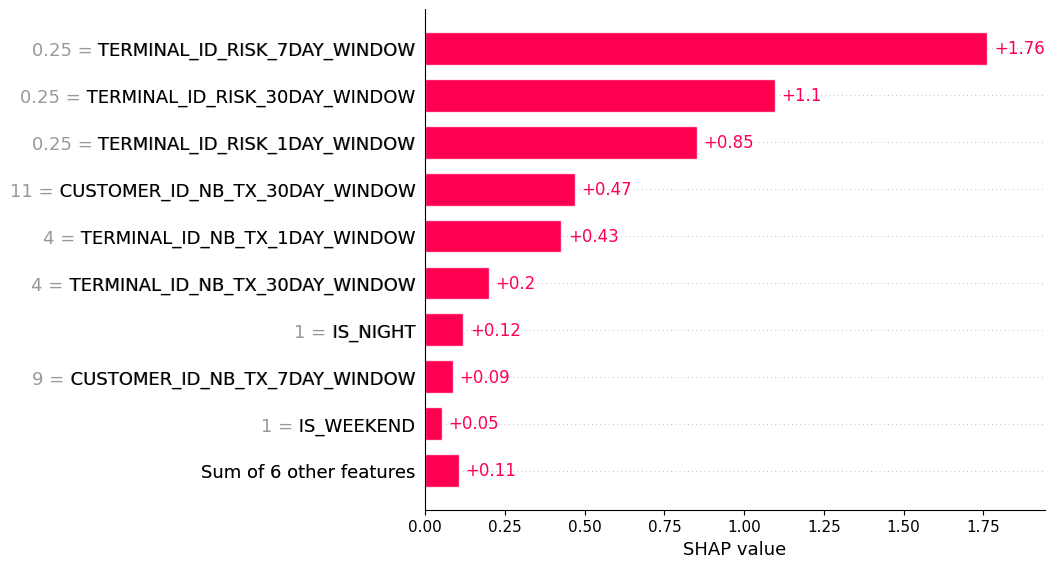

In [14]:
# Explain Anomaly using SHAP
h2o_wrapper = evaluate.H2OProbWrapper(model, model_parameters["feature_names"], model_parameters["output_name"])

predict_func = None
if model_name == "isolation_forest":
    predict_func = h2o_wrapper.predict_anomaly_score
elif model_name == "kmeans":
    predict_func = h2o_wrapper.predict_kmeans_distance
elif model_name == "lof":
    predict_func = h2o_wrapper.predict_lof_score
elif model_name == "svm":
    predict_func = h2o_wrapper.predict_svm_class
elif model_name == "auto_encoder":
    predict_func = h2o_wrapper.predict_reconstruction_error

shap_values = explain.explain_shap(
    data,
    9,
    predict_func,
    background_data,
    model_parameters,
)


In [15]:
# Commentary Generation
print(evaluate.generate_commentary(shap_values, model_parameters["feature_names"], 5))


Top 5 features affecting the anomaly score are:
1. TERMINAL_ID_RISK_7DAY_WINDOW increases the score by 1.76.
2. TERMINAL_ID_RISK_30DAY_WINDOW increases the score by 1.10.
3. TERMINAL_ID_RISK_1DAY_WINDOW increases the score by 0.85.
4. CUSTOMER_ID_NB_TX_30DAY_WINDOW increases the score by 0.47.
5. TERMINAL_ID_NB_TX_1DAY_WINDOW increases the score by 0.43.



In [11]:
# Shutdown H2O
h2o.cluster().shutdown()
